In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import csv
from collections import defaultdict
from utils.gini import gini

In [2]:
post_feature_table = open('output/reddit_submissions_basic_features_jan2012.tsv')
reader = csv.DictReader(post_feature_table, delimiter='\t')
days = {d: i for (i, d) in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])}
hours = range(24)

In [3]:
# List of post scores per username.
user_scores = defaultdict(list)
# List of post scores per hour of day. Hour 0 starts at midnight on Monday ET
hour_scores = [[] for _ in range(len(days)*len(hours))] 

cum_post_scores = []
cum_mean_post_scores = []
# cum_com_scores = []
scores = []

for (i, row) in enumerate(reader):
    # Update scorelist for author
    score = int(row['Score'])
    author = row['Author']
    
    if author != '[deleted]':
        cpsc = int(row['Author_Cum_Post_Score'])
        cp = int(row['Author_Cum_Posts'])
        
        if cp > 0:
            user_scores[author].append(score)
            cum_post_scores.append(cpsc)
            cum_mean_post_scores.append(float(cpsc)/cp)
            scores.append(score)
    
    # Update scorelist for hour of the week
    daystr = [d for d in days if row['Is_US_Eastern_' + d] == '1'][0]
    daynum = days[daystr]
    day_hournum = [h for h in hours if row['Is_US_Eastern_Hour_{}'.format(h)] == '1'][0]
    week_hournum = 24 * daynum + day_hournum
    hour_scores[week_hournum].append(score)

    if i % 100000 == 0:
        print('{} posts parsed'.format(i))
        
print('Done')

0 posts parsed
100000 posts parsed
200000 posts parsed
300000 posts parsed
400000 posts parsed
500000 posts parsed
600000 posts parsed
700000 posts parsed
800000 posts parsed
900000 posts parsed
1000000 posts parsed
1100000 posts parsed
1200000 posts parsed
1300000 posts parsed
Done


In [4]:
hourmeans = [np.mean(l) for l in hour_scores]

# Create smoothed version
window = 6
hourmeans_wrap = hourmeans[-window/2:] + hourmeans + hourmeans[:window/2]
hourmeans_smoothed = [np.mean(hourmeans_wrap[i-window/2:i+window/2+1])
                      for i in range(window/2, len(hourmeans)+window/2)]

# Plot 
plt.figure()
plt.plot(range(len(hourmeans)), hourmeans, label='raw', color=(0.7,0.7,0.7), linestyle='dashed')
plt.plot(range(len(hourmeans)), hourmeans_smoothed, color='r', label='smoothed')
plt.xlim((0, len(hours)*len(days)-1))
plt.ylim((0, 1.1*np.max(hourmeans)))
plt.xticks(range(0, (len(days)+1)*len(hours), len(hours)))
plt.xlabel('Hour of week')
plt.ylabel('Mean post score')
plt.legend()
plt.title('Mean post score throughout the week')

for d in days:
    pos = len(hours) * (days[d] + 1.0/2.2)
    plt.text(pos, 1, d[0])
    
plt.savefig('plots/post_trends.eps', format='eps', dpi=1000)

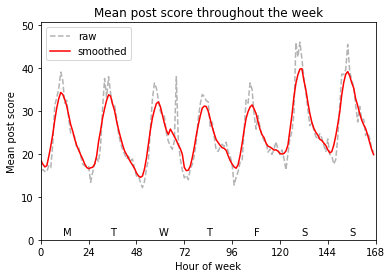

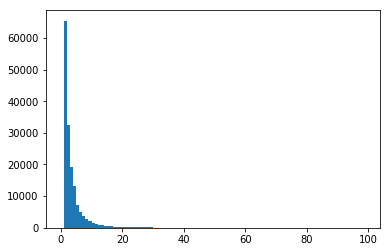

0.881995388394


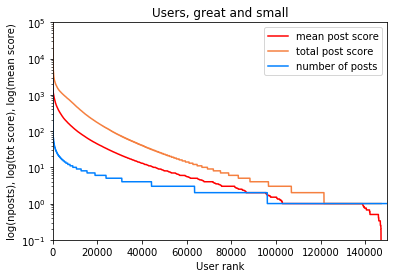

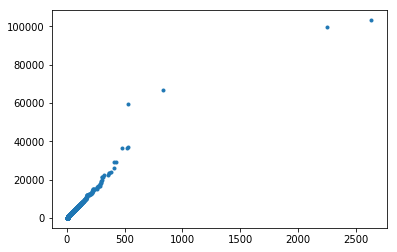

0.923241376535


In [5]:
userscore_means = sorted((np.mean(l) for l in user_scores.values()), reverse=True)
userscore_sums = sorted((np.sum(l) for l in user_scores.values()), reverse=True)
user_postnums = sorted((len(l) for l in user_scores.values()), reverse=True)

plt.figure()
plt.hist(user_postnums, bins=range(0,100,1))
plt.show()

plt.figure()
plt.semilogy(range(len(userscore_means)), userscore_means, color='r', label='mean post score')
plt.semilogy(range(len(userscore_sums)), userscore_sums, color=(0.96, 0.5, 0.25), label='total post score')
plt.semilogy(range(len(user_postnums)), user_postnums, color=(0,0.5,1), label='number of posts')

plt.xlim((0,150000))
plt.ylim((1e-1, 1e5))
plt.legend()
plt.xlabel('User rank')
plt.ylabel('log(nposts), log(tot score), log(mean score)')
plt.title('Users, great and small')
plt.savefig('plots/power_users.eps')

print(gini(np.array(userscore_sums, dtype=np.float64)))

plt.figure()
plt.scatter(user_postnums, userscore_sums, marker='.')
plt.show()

print(scipy.stats.pearsonr(user_postnums, userscore_sums)[0]**2)

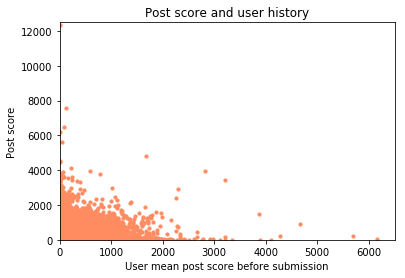

0.0204446875815


In [24]:
plt.figure()
plt.scatter(cum_mean_post_scores, scores, s=10, color='#FF8b60')
plt.xlim((0,6500))
plt.ylim((0,12500))
plt.xlabel('User mean post score before submission')
plt.ylabel('Post score')
plt.title('Post score and user history')
plt.show()

print(scipy.stats.pearsonr(cum_mean_post_scores, scores)[0]**2)